In [1]:
import numpy as np
#import collections
#import os
from abc import ABC, abstractmethod
from typing import Type
import pickle

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#from numba import jit, njit

In [2]:
show_logs = False

In [43]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_dataset():
    batch1 = unpickle("cifar-10-batches-py/data_batch_1")
    batch2 = unpickle("cifar-10-batches-py/data_batch_2")
    batch3 = unpickle("cifar-10-batches-py/data_batch_3")
    batch4 = unpickle("cifar-10-batches-py/data_batch_4")
    batch5 = unpickle("cifar-10-batches-py/data_batch_5")
    batch_test = unpickle("cifar-10-batches-py/test_batch")
    meta_data = unpickle("cifar-10-batches-py/batches.meta")

    X_train = np.array(np.vstack([batch1[b'data'], batch2[b'data'], batch3[b'data'], batch4[b'data'], batch5[b'data']]), dtype=float)
    y_train = np.hstack([batch1[b'labels'], batch2[b'labels'], batch3[b'labels'], batch4[b'labels'], batch5[b'labels']])
    X_test = np.array(batch_test[b'data'], dtype=float)
    y_test = np.array(batch_test[b'labels'])
    label_names = meta_data[b'label_names']

    return X_train, y_train, X_test, y_test, label_names

In [51]:
def one_hot(x, dim):
    return np.eye(dim)[x]

def data_loader():
    X_train, y_train, X_test, y_test, label_names = load_dataset()
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train, X_test = X_train.reshape(50000, 3, 32, 32), X_test.reshape(10000, 3, 32, 32)
    y_train, y_test = one_hot(y_train, 10), one_hot(y_test, 10)
    return X_train, y_train, X_test, y_test, label_names, scaler

# Yields minibatches of data
#@njit
def data_iterator(data, targets, batch_size):
    data_len = len(targets)
    batch_len = int(np.ceil(data_len / batch_size))
    print(f'training data shape is {data_len} and the number of batches is {batch_len}')

    for i in range(batch_len):
        start = i * batch_size
        end = (i+1) * batch_size
        x = data[start:end]
        y = targets[start:end]
        yield (x, y)

In [5]:
# From previous project
class Param(ABC):
    def __init__(self, is_trainable : bool = True, initialization_method : str = "random"):
        self.is_trainable = is_trainable
        self.initialization_method = initialization_method
        self.param = None
        self.dparam = None
        self.dparam_1 = None

    def __str__(self,):
        return self.param

    @abstractmethod
    def initialize_parameters(self, ):
        pass

class ScalarParam(Param):
    def __init__(self, trainable : bool = True, initialization_method : str = "normal"):
        super().__init__(trainable, initialization_method)
        self.initialize_parameters()

    def initialize_parameters(self,):
        if self.initialization_method=="normal":
            self.param = np.random.random()
        elif self.initialization_method=="zero":
            self.param = 0.0
        elif self.initialization_method=="one":
            self.param = 1.0

        self.dparam = 0
        self.dparam_1 = None

class ArrayParam(Param):
    def __init__(self, shape: tuple, is_trainable : bool = True, initialization_method : str = "normal", **kwargs):
        super().__init__(is_trainable, initialization_method)
        self.shape = shape
        self.loc = kwargs['loc'] if 'loc' in kwargs else 0.
        self.scale = kwargs['scale'] if 'scale' in kwargs else 1.
        self.low = kwargs['low'] if 'low' in kwargs else -0.1
        self.high = kwargs['high'] if 'high' in kwargs else 0.1
        self.initialize_parameters(self.loc, self.scale, self.low, self.high)

    def initialize_parameters(self, loc, scale, low, high):
        assert len(self.shape) >= 1, "shape must be a tuple of at least one element."

        if self.initialization_method=="normal":
            self.param = np.random.normal(loc=loc, scale=scale, size=self.shape)
        if self.initialization_method=="uniform":
            self.param = np.random.uniform(low=low, high=high, size=self.shape)
        elif self.initialization_method=="zero":
            self.param = np.zeros(shape=self.shape)
        elif self.initialization_method=="one":
            self.param = np.ones(shape=self.shape)
        elif self.initialization_method=='glorot':    
            a = np.sqrt(6.0 / np.sum(self.shape))
            self.param = np.random.uniform(-a, a, self.shape)
        elif self.initialization_method=='conv2d':
            # the shape of the kernel is (C_out, C_in, K, K)
            C_out, C_in, KH, KW = self.shape
            n = C_in * KH * KW
            stdv = 1. / np.sqrt(n)
            self.param = np.random.uniform(-stdv, stdv, size=self.shape)

        self.dparam = np.zeros_like(self.param)
        self.dparam_1 = None

class NN(ABC):
    def __init__(self):
        self.params: dict[str, ArrayParam] = {}
        self.forward_dict: dict[str, type] = {}
        self.params = {}

    @abstractmethod
    def forward(self,):
        pass
    
    @abstractmethod
    def backward(self,):
        pass

    def __str__(self,):
        return self.__class__.__name__

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

class Linear(NN):
    def __init__(self, dim_in, dim_out, weights_initialization_method='normal', bias: bool=True, bias_initialization_method='zero'):
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.bias = bias
        self.weights_initialization_method = weights_initialization_method
        self.bias_initialization_method = bias_initialization_method

        self.params : dict[str, ArrayParam] = {}
        self.params['w'] = ArrayParam(shape=(dim_in, dim_out), initialization_method=weights_initialization_method)
        if self.bias: self.params['b'] = ArrayParam(shape=(1, dim_out), initialization_method=bias_initialization_method)

    #@njit
    def forward(self, x, no_grad=False):
        if self.bias: a = x @ self.params['w'].param + self.params['b'].param
        else: a = x @ self.params['w'].param
        if not no_grad: 
            self.forward_dict = {
                'x': x,
                'a': a,
            }
        else:
            self.forward_dict = {
                'x': np.zeros_like(x),
                'a': np.zeros_like(a),
            }
        return a
    
    #@njit
    def backward(self, da):
        dw = self.forward_dict['x'].T @ da
        dx = da @ self.params['w'].param.T

        self.params['w'].dparam = dw

        if self.bias: 
            db = np.sum(da, axis=0)[np.newaxis, :]
            self.params['b'].dparam = db
        return dx
    
class Criterion(ABC):
    def __init__(self):
        self.forward_dict: dict[str, type] = {}
        self.params : dict[str, Type(Param)] = {}

    @abstractmethod
    def forward(self,):
        pass
    
    @abstractmethod
    def backward(self,):
        pass

    def __str__(self,):
        return self.__class__.__name__

    def __call__(self, x, y, no_grad=False):
        return self.forward(x, y, no_grad)
    
class CrossEntropy(Criterion):
    def __init__(self, epsilon=1e-20,):
        super().__init__()
        self.epsilon = epsilon

    #@njit
    def softmax(self, x):
        f = x - np.max(x, axis=1)[:,np.newaxis]
        p = np.exp(f) / np.sum(np.exp(f), axis=1)[:,np.newaxis]
        return p

    #@njit
    def forward(self, x, y, no_grad=False):
        m = y.shape[0]
        p = self.softmax(x)
        p[np.where(p < self.epsilon)] = self.epsilon
        p[np.where(p > 1 - self.epsilon)] = 1 - self.epsilon
        loss = - np.sum(y * np.log(p)) / m
        if not no_grad: 
            self.forward_dict = {
                'x': x,
                'y': y,
                'p': p,
                'loss': loss,
            }
        return p, loss
    
    #@njit
    def backward(self, out):
        m = self.forward_dict['y'].shape[0]
        grad = out - self.forward_dict['y']
        grad = grad/m # to take the mean across the batch
        return grad

In [6]:
class Activation():
    @staticmethod
    #@njit
    def relu(x, grad=False):
        if grad:
            return (x > 0) * 1
        else:
            return np.maximum(0, x)
        
    @staticmethod
    #@njit
    def sigmoid(x, grad=False):
        if grad:
            return (1 / (1 + np.exp(-x)))*(1 - (1 / (1 + np.exp(-x))))
        return 1 / (1 + np.exp(-x))

    @staticmethod
    #@njit
    def tanh(x, grad=False):
        if grad:
            return 1 - np.tanh(x)**2
        return np.tanh(x)      
    
class Optimizer():
    def __init__(self, ):
        pass

    def __str__(self,):
        return self.__class__.__name__

    @abstractmethod
    def step(self, ):
        pass

    def get_model_parameters(self, layers):
        if isinstance(layers, list):
            #print(f"list {layers}")
            elt = layers.pop(0)
            if len(layers) > 0:
                return self.get_model_parameters(elt) + self.get_model_parameters(layers)
            else:
                return self.get_model_parameters(elt)
        elif isinstance(layers, NN):
            #print(f"NN {layers}")
            if layers.params:
                return self.get_model_parameters(layers.params)
            elif layers.layers:
                return self.get_model_parameters(layers.layers)
            else:
                raise Exception('error type 2 ', layers.__class__.__name__)
        elif isinstance(layers, Criterion):
            return []
        elif isinstance(layers, dict):
            #print(f"dict {layers}")
            return list(layers.values())
        else:
            raise Exception('error type 1 ', layers.__class__.__name__)

    #@njit
    def zero_grad(self, ):
        # if to be rewritten, redirect to a function directly inside the class
        for param in self.params:
            if param.is_trainable:
                param.dparam = np.zeros_like(param.param)

class SGDOptimizer(Optimizer):
    def __init__(self, model, lr, mu_momentum=0., tau_dampening=0., nesterov=False, weight_decay=0.,):
        super().__init__()
        self.lr = lr
        self.mu_momentum = mu_momentum
        self.model = model
        self.tau_dampening = tau_dampening
        self.nesterov = nesterov
        self.weight_decay = weight_decay

        self.params = self.get_model_parameters(self.model.layers)

    #@njit
    def step(self, ):
        for param in self.params:
            if param.is_trainable:
                grad_t = param.dparam
                if self.weight_decay != 0.:
                    grad_t += self.weight_decay * param.param
                if self.mu_momentum != 0.:
                    bt_1 = param.dparam_1
                    if bt_1 is not None:
                        bt = self.mu_momentum * bt_1 + (1 - self.tau_dampening) * grad_t
                    else:
                        bt = grad_t

                    if self.nesterov:
                        grad_t += self.mu_momentum * bt
                    else:
                        grad_t = bt

                param.param -= grad_t * self.lr

                # post update
                param.dparam_1 = param.dparam

class AdamOptimizer(Optimizer):
    def __init__(self, model, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__()
        self.model = model
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 1.

        self.params = self.get_model_parameters(self.model.layers)
        print(len(self.params), self.params)
        self.m_dw, self.v_dw = self.init_moments()

    def init_moments(self, ):
        m_dw, v_dw = [], []

        for param in self.params:
            m_dw.append(np.zeros_like(param))
            v_dw.append(np.zeros_like(param))

        return m_dw, v_dw

    #@njit
    def step(self, ):
        for i, param in enumerate(self.params):
            if param.is_trainable:
                ## momentum beta 1
                # *** weights *** #
                self.m_dw[i] = self.beta1 * self.m_dw[i] + (1-self.beta1) * param.dparam

                ## rms beta 2
                # *** weights *** #
                self.v_dw[i] = self.beta2 * self.v_dw[i] + (1-self.beta2) * (param.dparam**2)

                ## bias correction
                m_dw_corr = self.m_dw[i]/(1-self.beta1**self.t)
                v_dw_corr = self.v_dw[i]/(1-self.beta2**self.t)

                ## update weights and biases
                param.param -=  self.lr * (m_dw_corr/(np.sqrt(v_dw_corr)+self.epsilon))
        self.t += 1

    #@njit
    def gradient_array(self, ):
        return np.concatenate([param.dparam.ravel() for param in self.params])

    #@njit
    def clip_gradient(self, max_threshold):
        gradient_arr = self.gradient_array()
        norm_ = np.linalg.norm(gradient_arr)
        if norm_ >= max_threshold:
            for param in self.params:
                param.dparam = max_threshold * param.dparam / norm_

    #@njit
    def clip_gradient_v2(self, max_threshold):
        for param in self.params:
            norm_ = np.linalg.norm(param.dparam)
            if norm_ >= max_threshold:
                param.dparam = max_threshold * param.dparam / norm_

# Prepare Data

In [52]:
X_train, y_train, X_test, y_test, label_names, scaler = data_loader()
#X_train, y_train, X_test, y_test = X_train[:1000], y_train[:1000], X_test[:1000], y_test[:1000]
X_train.shape, X_test.shape, y_train.shape, y_test.shape, label_names

((50000, 3, 32, 32),
 (10000, 3, 32, 32),
 (50000, 10),
 (10000, 10),
 [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'])

# CNN

In [8]:
class ReLU(NN):
    def __init__(self,):
        super().__init__()

    #@njit
    def forward(self, x, no_grad=False):
        out = Activation.relu(x)
        if not no_grad:
            self.forward_dict = {
                'x': x,
                'out': out,
            }
        return out

    #@njit
    def backward(self, dout):
        dx = dout * Activation.relu(self.forward_dict['x'], grad=True)
        return dx

class Conv2d(NN):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, initialization_method='conv2d'):
        super().__init__()
        self.in_channels, self.out_channels, self.kernel_size, self.stride, self.initialization_method = in_channels, out_channels, kernel_size, stride, initialization_method
        self.params['w'] = ArrayParam(shape=(out_channels, in_channels, kernel_size, kernel_size), initialization_method=initialization_method)

    #@njit
    def forward(self, x, no_grad=False):
        B, _, H_in, W_in = x.shape
        H_out, W_out = int(np.floor((H_in - (self.kernel_size - 1) - 1) / self.stride + 1)), int(np.floor((W_in - (self.kernel_size - 1) - 1) / self.stride + 1))
        kernel = np.flip(self.params['w'].param, axis=(-1,-2))
        #kernel = self.params['w'].param
        out = np.zeros(shape=(B, self.out_channels, H_out, W_out))
        x_expanded = np.repeat(x[:,np.newaxis], self.out_channels, axis=1) # (B, C_out, C_in, H, W)
        for w in range(W_out):
            for h in range(H_out):
                h_start, h_end = h*self.stride, h*self.stride+self.kernel_size
                w_start, w_end = w*self.stride, w*self.stride+self.kernel_size
                #######################################
                patch = x_expanded[:,:,:,h_start:h_end, w_start:w_end]
                out[:,:,h,w] = np.sum(patch * kernel, axis=(-3,-2,-1))

        if not no_grad:
            self.forward_dict = {
                'x': x,
                'x_expanded': x_expanded,
                'kernel': kernel,
                'out': out,
                'H_out': H_out,
                'W_out': W_out,
            }
        return out # (B, C_out, H, W)

    #@njit
    def backward(self, dout):
        dx = np.zeros_like(self.forward_dict['x'])
        dw = np.zeros_like(self.params['w'].dparam)
        for w in range(self.forward_dict['W_out']):
            for h in range(self.forward_dict['H_out']):
                h_start, h_end = h*self.stride, h*self.stride+self.kernel_size
                w_start, w_end = w*self.stride, w*self.stride+self.kernel_size
                #######################################
                # definitly redo the next two lines
                dx[:,:,h_start:h_end, w_start:w_end] += (self.forward_dict['kernel'].T @ dout[:,:,h,w].T).T                
                dw += (self.forward_dict['x'][:,:,h_start:h_end, w_start:w_end].T @ dout[:,:,h,w]).T
        self.params['w'].dparam = np.flip(dw, axis=(-1,-2))
        #self.params['w'].dparam = dw
        return dx

class MaxPool(NN):
    def __init__(self, kernel_size, stride=1):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride

    #@njit
    def forward(self, x, no_grad=False):
        B, in_channels, H_in, W_in = x.shape
        H_out, W_out = int(np.floor((H_in - (self.kernel_size - 1) - 1) / self.stride + 1)), int(np.floor((W_in - (self.kernel_size - 1) - 1) / self.stride + 1))
        out = np.zeros(shape=(B, in_channels, H_out, W_out))
        x_grad = np.zeros(shape=(B, in_channels, H_in, W_in))
        for w in range(W_out):
            for h in range(H_out):
                h_start, h_end = h*self.stride, h*self.stride+self.kernel_size
                w_start, w_end = w*self.stride, w*self.stride+self.kernel_size
                #######################################
                patch = x[:,:,h_start:h_end, w_start:w_end].reshape(B, in_channels, -1)
                x_grad_window = np.zeros_like(patch)
                argmax_ = np.argmax(patch, axis=-1)
                I,J = np.ogrid[:B,:in_channels]
                out[:,:,h,w] = patch[I,J, argmax_]
                x_grad_window[I,J, argmax_] = 1
                x_grad[:,:,h_start:h_end, w_start:w_end] += x_grad_window.reshape(B, in_channels, self.kernel_size, self.kernel_size)

        if not no_grad:
            self.forward_dict = {
                'x': x,
                'x_grad': x_grad,
                'out': out,
                'in_channels': in_channels,
                'H_out': H_out,
                'W_out': W_out,
                'B': B,
            }
        return out # (B, C_in, H, W)

    #@njit
    def backward(self, dout):
        dx = np.zeros_like(self.forward_dict['x'])
        for w in range(self.forward_dict['W_out']):
            for h in range(self.forward_dict['H_out']):
                h_start, h_end = h*self.stride, h*self.stride+self.kernel_size
                w_start, w_end = w*self.stride, w*self.stride+self.kernel_size
                #######################################
                dx[:,:,h_start:h_end, w_start:w_end] += self.forward_dict['x_grad'][:,:,h_start:h_end, w_start:w_end] * dout[:,:,h,w][:,:,np.newaxis,np.newaxis]
        return dx

In [9]:
class CNN():
    def __init__(self,):
        self.conv2d1: Conv2d = Conv2d(3, 6, 5)
        self.relu_conv1 : ReLU = ReLU()
        self.maxpool1: MaxPool = MaxPool(kernel_size=2, stride=2)
        self.conv2d2: Conv2d = Conv2d(6, 16, 5)
        self.relu_conv2 : ReLU = ReLU()
        self.maxpool2: MaxPool = MaxPool(kernel_size=2, stride=2)
        self.fc1: Linear = Linear(16 * 5 * 5, 120, bias=False, weights_initialization_method="glorot")
        self.relu1 : ReLU = ReLU()
        self.fc2: Linear = Linear(120, 84, bias=False, weights_initialization_method="glorot")
        self.relu2 : ReLU = ReLU()
        self.fc3: Linear = Linear(84, 10, bias=False, weights_initialization_method="glorot")
        self.cross_entropy: CrossEntropy = CrossEntropy()

        self.layers = [
            self.conv2d1,
            #self.relu_conv1,
            #self.maxpool1,
            self.conv2d2,
            #self.relu_conv1,
            #self.maxpool2,
            self.fc1,
            self.fc2,
            self.fc3,
        ]

    def __call__(self, x, y, no_grad=False):
        return self.forward(x, y, no_grad)

    #@njit
    def forward(self, x, y, no_grad=False):
        #x = x.reshape(-1, 3, 32, 32)
        out = self.conv2d1(x, no_grad)
        out = self.relu_conv1(out, no_grad)
        out = self.maxpool1(out, no_grad)
        out = self.conv2d2(out, no_grad)
        out = self.relu_conv2(out, no_grad)
        out = self.maxpool2(out, no_grad)
        out = out.reshape(-1, self.maxpool2.forward_dict['in_channels'] * self.maxpool2.forward_dict['H_out'] * self.maxpool2.forward_dict['W_out'])
        out = self.fc1(out, no_grad)
        out = self.relu1(out, no_grad)
        out = self.fc2(out, no_grad)
        out = self.relu2(out, no_grad)
        logits = self.fc3(out, no_grad)
        probas, losses = self.cross_entropy(logits, y, no_grad)
        return probas, losses
    
    #@njit
    def backward(self, dout):
        do = self.cross_entropy.backward(dout)
        do = self.fc3.backward(do)
        do = self.relu2.backward(do)
        do = self.fc2.backward(do)
        do = self.relu1.backward(do)
        do = self.fc1.backward(do)
        do = do.reshape(-1, self.maxpool2.forward_dict['in_channels'], self.maxpool2.forward_dict['H_out'], self.maxpool2.forward_dict['W_out'])
        do = self.maxpool2.backward(do)
        do = self.relu_conv2.backward(do)
        do = self.conv2d2.backward(do)
        do = self.maxpool1.backward(do)
        do = self.relu_conv1.backward(do)
        do = self.conv2d1.backward(do)

In [10]:
#@njit
def compute_loss_and_accuracy(model, X, y):
    out, loss = model(x=X, y=y, no_grad=True)
    predictions = np.argmax(out, axis=1) # Change y to integers
    y_ = np.argmax(y, axis=1)
    accuracy = np.mean(y_ == predictions)
    return loss, accuracy

#@njit
def evaluate_model(model, X, y, batch_size):
    n_batches = int(np.ceil(X.shape[0] / batch_size))
    loss, accuracy = 0., 0.
    for batch in range(n_batches):
        minibatchX = X[batch_size * batch:batch_size * (batch + 1)]
        minibatchY = y[batch_size * batch:batch_size * (batch + 1)]
        current_loss, current_accuracy = compute_loss_and_accuracy(model, minibatchX, minibatchY)
        loss, accuracy = loss + current_loss, accuracy + current_accuracy
    loss, accuracy = loss/n_batches, accuracy/n_batches
    return loss, accuracy

In [19]:
batch_size = 128
n_epochs = 10

In [22]:
model = CNN()
#optimizer = SGDOptimizer(model=model, lr=0.01, mu_momentum=0., nesterov=False, weight_decay=0.)
optimizer = AdamOptimizer(model=model, lr=0.001)

5 [<__main__.ArrayParam object at 0x000001AA17BA71C0>, <__main__.ArrayParam object at 0x000001AA17A97FA0>, <__main__.ArrayParam object at 0x000001AA17BA73D0>, <__main__.ArrayParam object at 0x000001AA17BA72B0>, <__main__.ArrayParam object at 0x000001AA17BA7790>]


In [20]:
# training
#@njit
def train_and_evaluate(model: CNN, optimizer: AdamOptimizer):
    for epoch in range(n_epochs):
        print(f"######################### Epoch {epoch} ###########################")
        for step, (x, y) in enumerate(data_iterator(X_train, y_train, batch_size)):
            inputs_ = x
            targets_ = y
            
            optimizer.zero_grad()
            outputs, losses = model(inputs_, targets_, no_grad=False)
            model.backward(outputs)
            optimizer.step()

        #train_loss, train_accuracy = evaluate_model(model, X_train, y_train, batch_size)
        valid_loss, valid_accuracy = evaluate_model(model, X_test, y_test, batch_size)

        #print("train loss:", train_loss)
        print("valid loss:", valid_loss)
        #print("train acc:", train_accuracy)
        print("valid acc:", valid_accuracy)

In [23]:
train_and_evaluate(model, optimizer)

######################### Epoch 0 ###########################
training data shape is 50000 and the number of batches is 391
valid loss: 1.4088714067334824
valid acc: 0.4877373417721519
######################### Epoch 1 ###########################
training data shape is 50000 and the number of batches is 391
valid loss: 1.284639838431713
valid acc: 0.5443037974683544
######################### Epoch 2 ###########################
training data shape is 50000 and the number of batches is 391
valid loss: 1.220209632467983
valid acc: 0.5661590189873418
######################### Epoch 3 ###########################
training data shape is 50000 and the number of batches is 391
valid loss: 1.1748867465450663
valid acc: 0.5850474683544303
######################### Epoch 4 ###########################
training data shape is 50000 and the number of batches is 391
valid loss: 1.158882967814913
valid acc: 0.5928599683544303
######################### Epoch 5 ###########################
training data sh

# Pytorch CNN

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
@torch.no_grad()
def compute_loss_and_accuracy_torch(model, criterion, X, y):
    y_ = torch.argmax(y, axis=1)
    out = model(X)
    loss = criterion(out, y)
    predictions = torch.argmax(out, axis=1)
    accuracy = torch.mean(y_ == predictions, dtype=torch.float)
    return loss.item(), accuracy.item()

def evaluate_model_torch(model, criterion, X, y, batch_size):
    n_batches = int(np.ceil(X.shape[0] / batch_size))
    loss, accuracy = 0., 0.
    for batch in range(n_batches):
        minibatchX = X[batch_size * batch:batch_size * (batch + 1)]
        minibatchY = y[batch_size * batch:batch_size * (batch + 1)]
        #current_loss, current_accuracy = compute_loss_and_accuracy_torch(model, criterion, minibatchX.to(device), minibatchY.to(device))
        current_loss, current_accuracy = compute_loss_and_accuracy_torch(model, criterion, minibatchX, minibatchY)
        loss, accuracy = loss + current_loss, accuracy + current_accuracy
    loss, accuracy = loss/n_batches, accuracy/n_batches
    return loss, accuracy

In [14]:
class TorchCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=False)

        #for param in self.fc1.parameters():
        #    param.requires_grad = False
        #for param in self.fc2.parameters():
        #    param.requires_grad = False

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
n_epochs = 17
batch_size = 128

net = TorchCNN()
criterion_torch = nn.CrossEntropyLoss()
optimizer_torch = optim.Adam(net.parameters(), lr=0.001)

#net = net.to(device)

In [18]:
# training
for epoch in range(n_epochs):
    print(f"######################### Epoch {epoch} ###########################")
    for step, (x, y) in enumerate(data_iterator(X_train, y_train, batch_size)):

        #inputs_ = torch.tensor(x, dtype=torch.float).to(device)
        #targets_ = torch.tensor(y, dtype=torch.float).to(device)

        inputs_ = torch.tensor(x, dtype=torch.float)
        targets_ = torch.tensor(y, dtype=torch.float)
        
        optimizer_torch.zero_grad()

        outputs = net(inputs_)
        loss = criterion_torch(outputs, targets_)
        loss.backward()
        optimizer_torch.step()

    train_loss, train_accuracy = evaluate_model_torch(net, criterion_torch, torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train), batch_size)
    valid_loss, valid_accuracy = evaluate_model_torch(net, criterion_torch, torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test), batch_size)

    print("train loss:", train_loss)
    print("valid loss:", valid_loss)
    print("train acc:", train_accuracy)
    print("valid acc:", valid_accuracy)

######################### Epoch 0 ###########################
training data shape is 50000 and the number of batches is 391
train loss: 1.5534063773454063
valid loss: 1.5502360688855494
train acc: 0.43306026213309345
valid acc: 0.4307753164556962
######################### Epoch 1 ###########################
training data shape is 50000 and the number of batches is 391
train loss: 1.3990609387584862
valid loss: 1.4108058123238152
train acc: 0.49525255757524533
valid acc: 0.4886273734177215
######################### Epoch 2 ###########################
training data shape is 50000 and the number of batches is 391
train loss: 1.302046198336287
valid loss: 1.332081744034647
train acc: 0.5345668158567775
valid acc: 0.5200751582278481
######################### Epoch 3 ###########################
training data shape is 50000 and the number of batches is 391
train loss: 1.231077984094284
valid loss: 1.2783376200216745
train acc: 0.5603420716112532
valid acc: 0.5420292721518988
#################

# Visualizing Feature maps

In [47]:
label_names

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [24]:
net.conv1.weight.shape

torch.Size([6, 3, 5, 5])

In [94]:
print(y_train[10])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [104]:
label_names[np.argmax(y_train[1])]

b'truck'

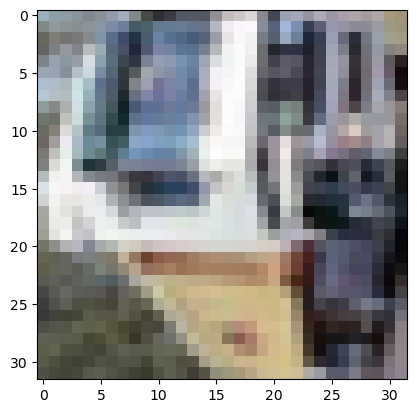

In [103]:
image = scaler.inverse_transform(X_train[1].flatten()[np.newaxis]).reshape(32,32,3, order='F').astype(int)
plt.imshow(image)

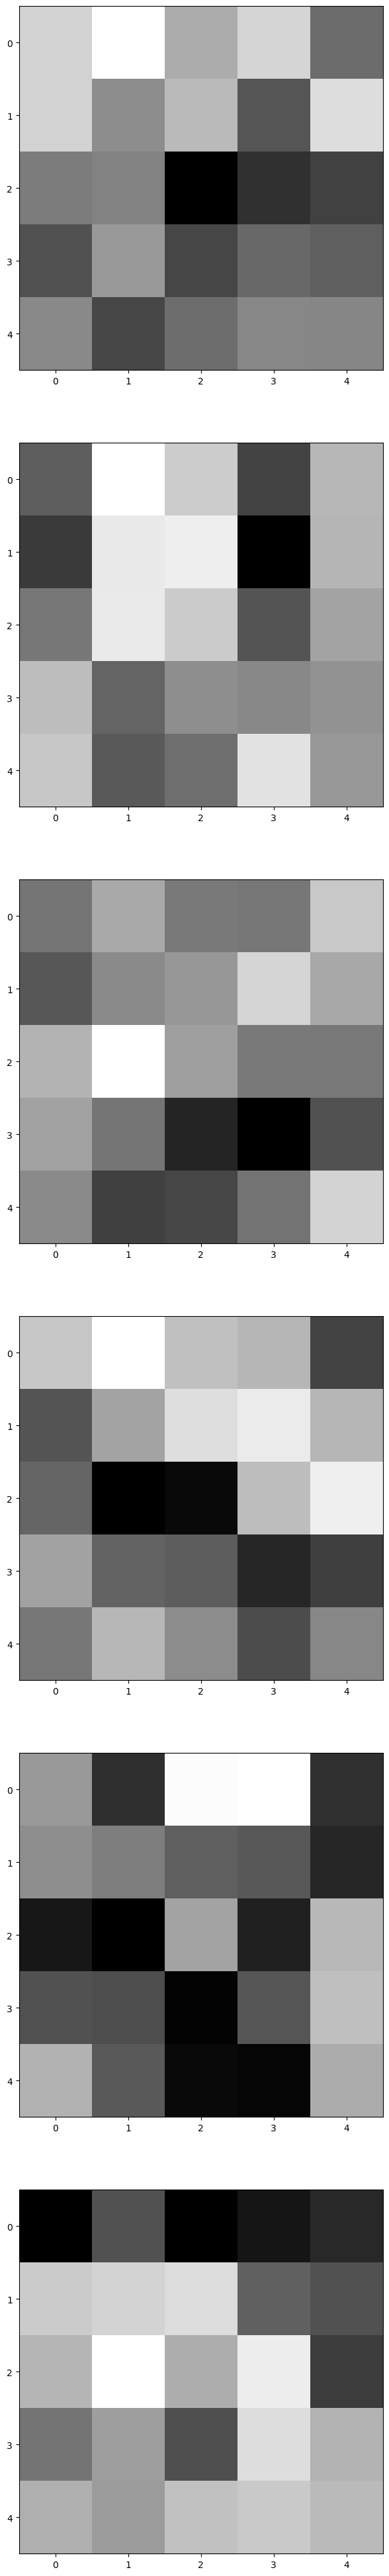

In [31]:
n_filters = 6
ix=1
fig = plt.figure(figsize=(50,50))
for i in range(n_filters):
    # get the filters
    f = net.conv1.weight[i].detach().numpy()
    # subplot for 12 filters and first channel
    plt.subplot(n_filters, 1, ix)
    plt.imshow(f[0], cmap='gray')
    ix+=1
#plot the filters 
plt.show()

In [107]:
image_forwarded = net.conv1(torch.tensor(X_train[1][np.newaxis].reshape(1,3,32,32), dtype=torch.float))

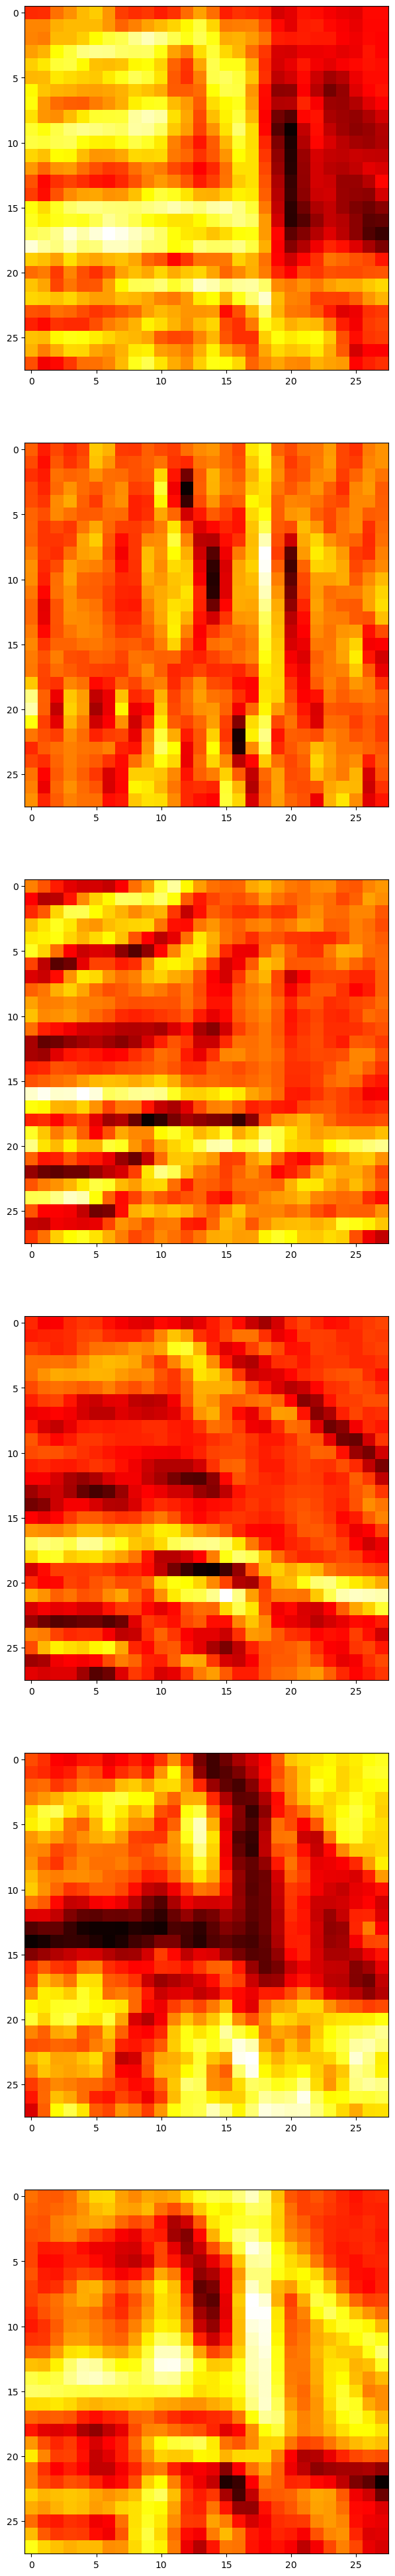

In [113]:
n_filters = 6
ix=1
fig = plt.figure(figsize=(50,50))
for i in range(n_filters):
    # get the filters
    f = image_forwarded[0].detach().numpy()
    # subplot for 12 filters and first channel
    plt.subplot(n_filters, 1, ix)
    plt.imshow(f[i], cmap='hot')
    ix+=1
#plot the filters 
plt.show()